In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import skfda
from skfda.representation.interpolation import SplineInterpolation
from skfda.exploratory.visualization import Boxplot
import datetime as dt

In [32]:
# Variabili globali

path = 'pala_ok/acquisizione 22-05-2023/'

In [33]:
allacqui = []

# Andiamo a prendere tutti i path dei vari file

path_acquisizioni = [f for f in listdir(path) if isfile(join(path, f))]


In [34]:
# Abbiamo usato il range siccome i csv hanno separatori diversi

for a,b in zip(path_acquisizioni,range(0,15)):
    if(b < 4 or b > 11):
        allacqui.append(pd.read_csv(path+a,sep='\t'))
    else:
        allacqui.append(pd.read_csv(path+a,sep='\t'))

In [35]:
# Check delle dimensioni

print(type(allacqui[4][:10].mean()))

for a in range(len(allacqui)):
    print(allacqui[a].shape)

<class 'pandas.core.series.Series'>
(40, 2)
(30192, 2)
(29638, 2)
(29639, 2)
(40, 2)
(29272, 2)
(29295, 2)
(29295, 2)
(40, 2)
(29767, 2)
(29619, 2)
(29619, 2)
(40, 2)
(28986, 2)
(29499, 2)


In [36]:
media_mobile_ni = pd.DataFrame(columns=[])

for b in range(0,allacqui[4].shape[0],1):
    media_mobile_ni = pd.concat([media_mobile_ni,pd.DataFrame(allacqui[4][b:10+b].mean()).transpose()],ignore_index=True)

In [37]:
print(type(allacqui[0]))
print(allacqui[0].head(10))

<class 'pandas.core.frame.DataFrame'>
               time  pwm_percent
0  1684770601025368            2
1  1684770604032476            7
2  1684770607045914           12
3  1684770610059281           17
4  1684770613074306           22
5  1684770616075352           27
6  1684770619088353           32
7  1684770622096963           37
8  1684770625107251           42
9  1684770628120158           47


<Axes: >

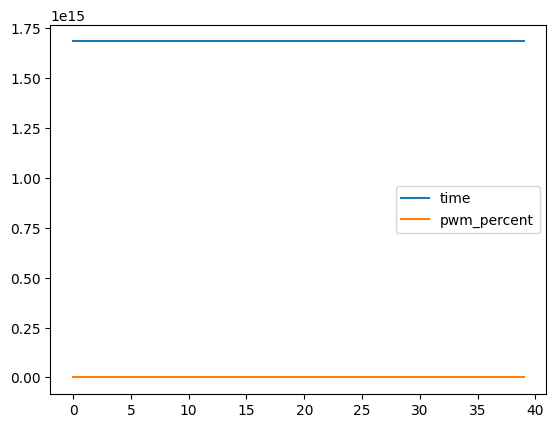

In [38]:
allacqui[0].plot()

In [39]:
# Andiamo a lavorare sui dati di national instrument, ne riduciamo le dimensioni usando la media

data_matrix = allacqui[3]['volts']
grid_points = allacqui[3]['time']

fd_manu = skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name="Datagrid di esempio",
    argument_names=('time',),
    coordinate_names=('values',),
    interpolation=SplineInterpolation(interpolation_order=3)
)

c:\Users\pc\anaconda3\envs\manutenzione\lib\site-packages\skfda\exploratory\depth\multivariate.py:276: RuntimeWarning: invalid value encountered in divide
  return (  # type: ignore[no-any-return]


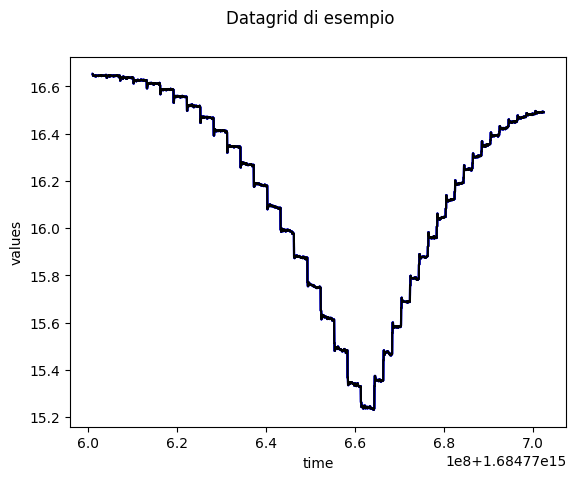

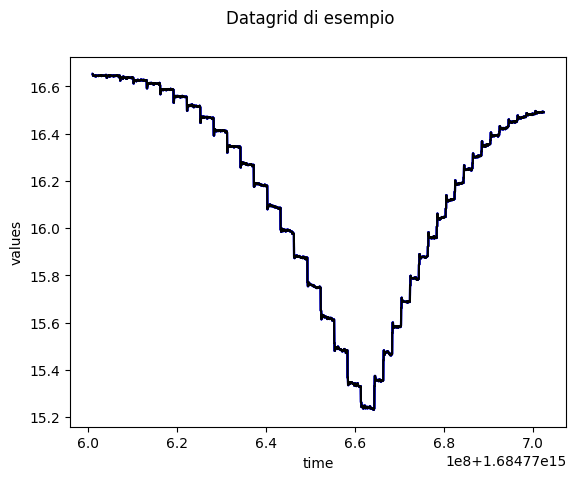

In [40]:
fdBoxplot = Boxplot(fd_manu)
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()

In [ ]:
# Andiamo a creare una lista di soli input a cui dobbiamo effettuare un'operazione di ridimensionamento

all_input = []

for a in range(0,len(allacqui),4):
    all_input.append(allacqui[a])

In [60]:
timestamp_array = allacqui[0]['time']

PWMarray = allacqui[0]['pwm_percent']

PWM_output = []

off_setList = [
        x - allacqui[1]['Time'][0] for x in timestamp_array if (x-allacqui[1]['Time'][0] > 0)
    ]

'''for a in allacqui[1]['Time']:
    off_setList = [
        x - a for x in timestamp_array if (x-a > 0)
    ]
    if(len(off_setList) == 0):
        PWM_output.append(0)
    else:
        PWM_output.append(PWMarray[len(off_setList)-1])'''



"for a in allacqui[1]['Time']:\n    off_setList = [\n        x - a for x in timestamp_array if (x-a > 0)\n    ]\n    if(len(off_setList) == 0):\n        PWM_output.append(0)\n    else:\n        PWM_output.append(PWMarray[len(off_setList)-1])"

In [72]:
print(len(off_setList))
print(dt.datetime.utcfromtimestamp(allacqui[0]['time'][0]))

39


OSError: [Errno 22] Invalid argument

In [58]:
print(PWM_output)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

In [50]:
# Andiamo a definire un datagrid per ogni dataframe

all_data_grid = []

'''for a,b in zip(allacqui,path_acquisizioni):
    
    data_matrix = a[a.columns.values[1]]
    data_matrix_2 = 
    grid_points = a[a.columns.values[0]]

    all_data_grid.append(skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name=b,
    argument_names=(a.columns.values[0],),
    coordinate_names=(a.columns.values[1],),
    interpolation=SplineInterpolation(interpolation_order=1)
        ))
    '''

'for a,b in zip(allacqui,path_acquisizioni):\n    \n    data_matrix = a[a.columns.values[1]]\n    data_matrix_2 = \n    grid_points = a[a.columns.values[0]]\n\n    all_data_grid.append(skfda.FDataGrid(\n    data_matrix=data_matrix,\n    grid_points=grid_points,\n    dataset_name=b,\n    argument_names=(a.columns.values[0],),\n    coordinate_names=(a.columns.values[1],),\n    interpolation=SplineInterpolation(interpolation_order=1)\n        ))\n    '

In [52]:
print(all_input[1].head(10))

               time  pwm_percent
0  1684770885205270            2
1  1684770888215882            7
2  1684770891223207           12
3  1684770894238310           17
4  1684770897249461           22
5  1684770900264376           27
6  1684770903268326           32
7  1684770906283716           37
8  1684770909294834           42
9  1684770912307318           47


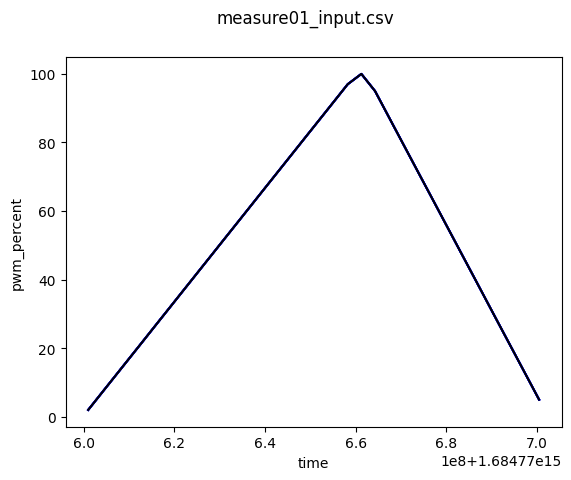

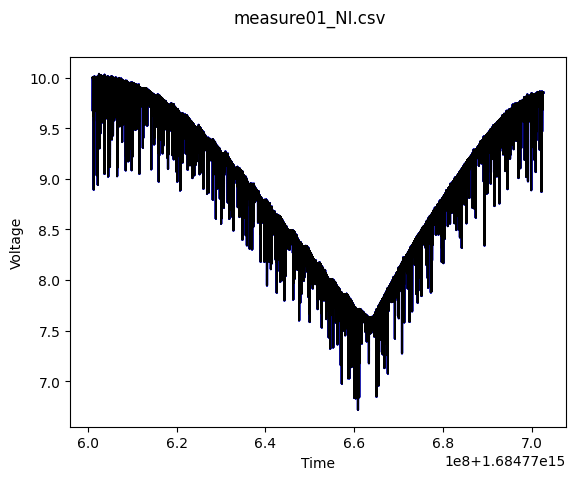

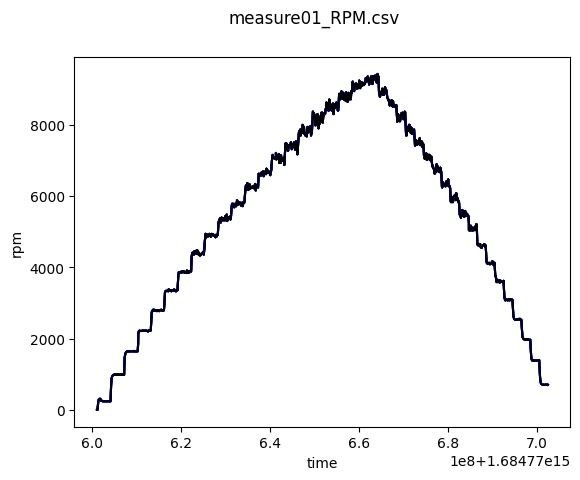

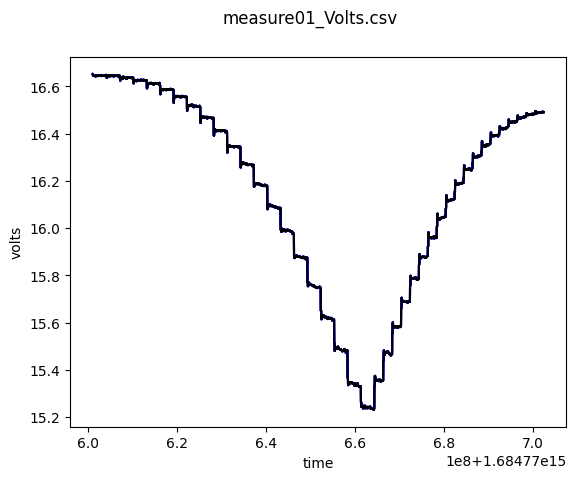

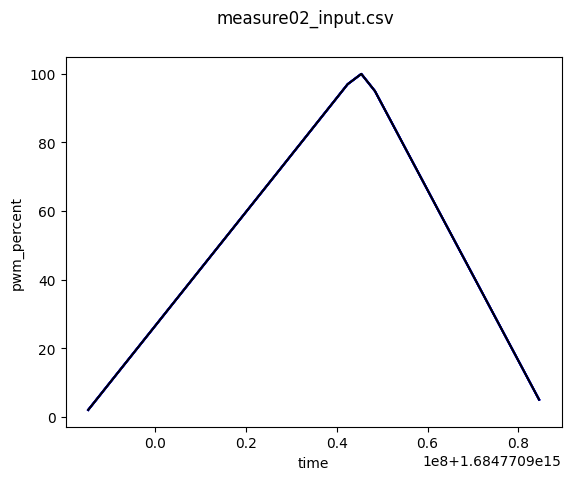

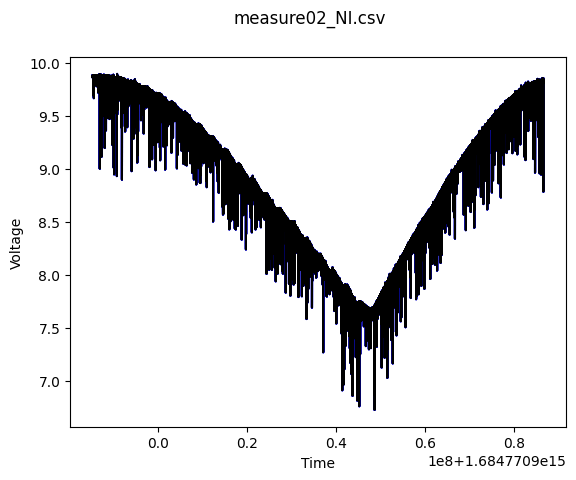

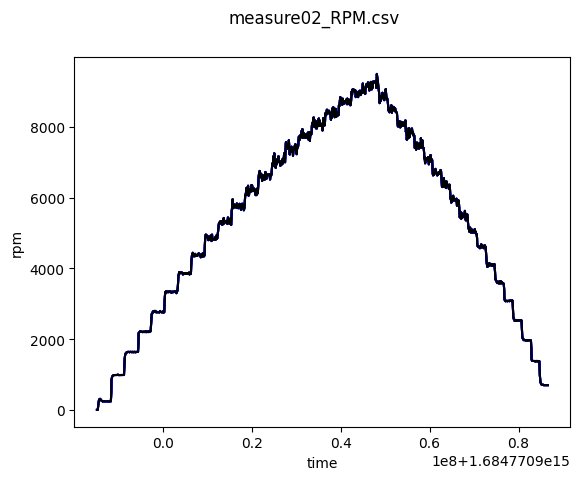

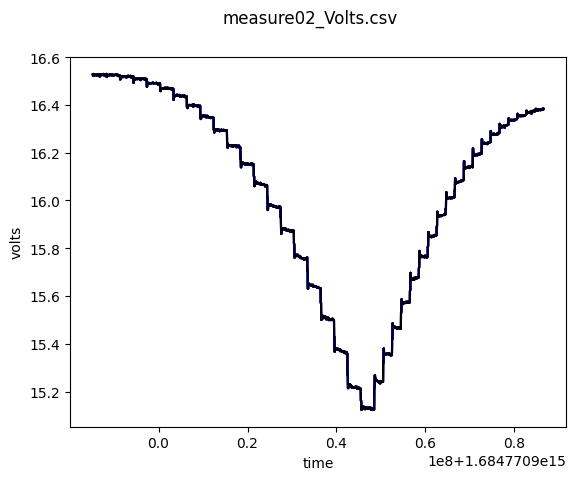

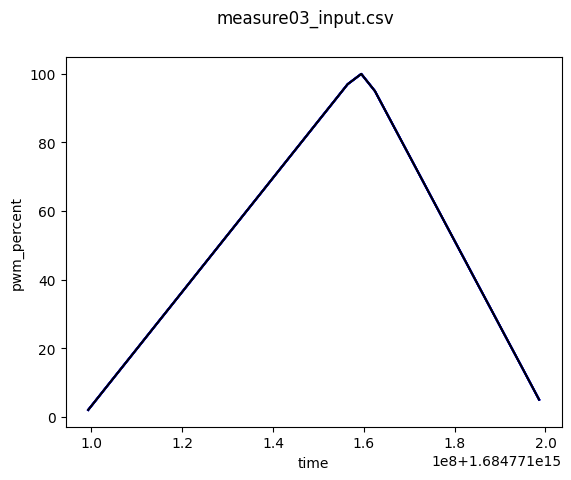

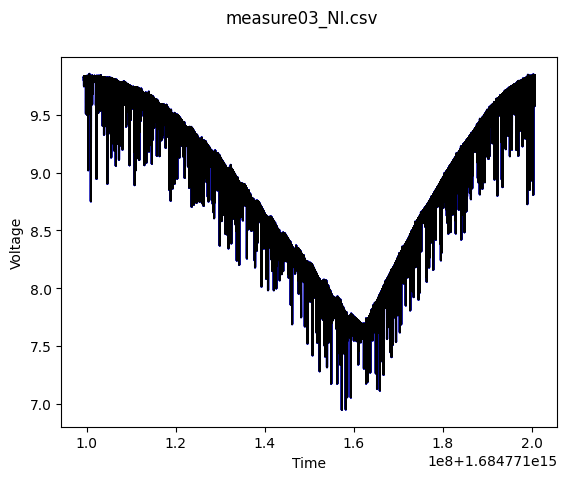

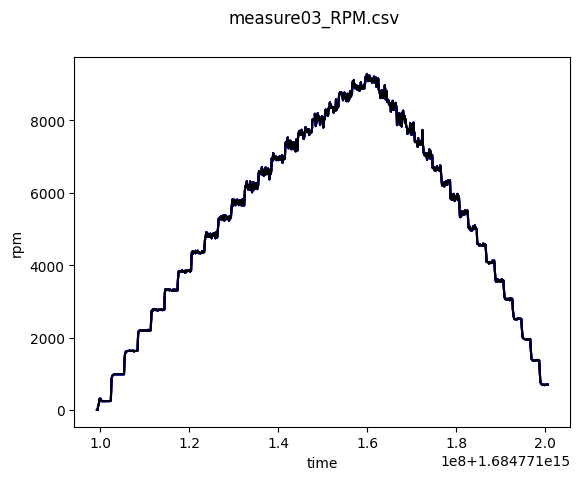

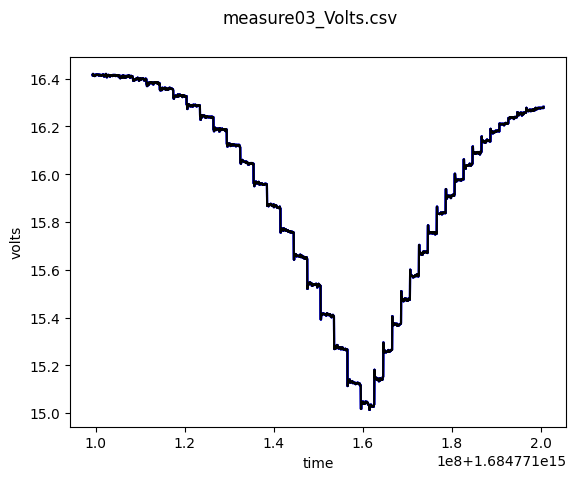

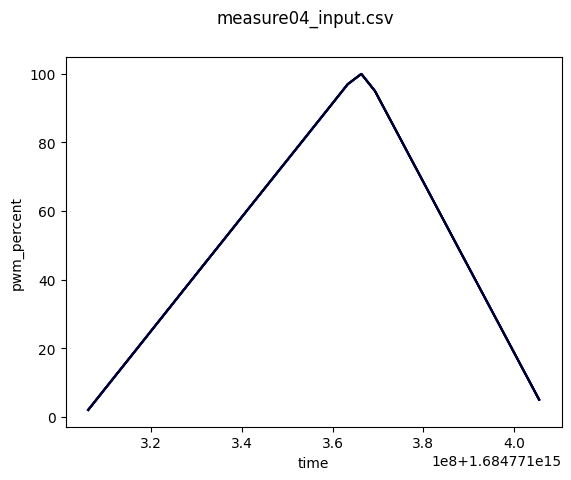

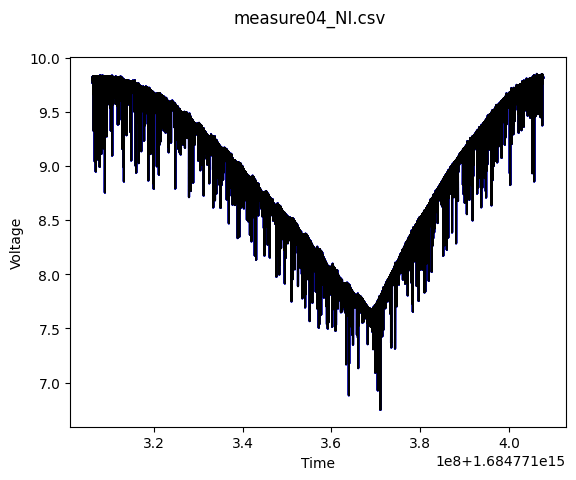

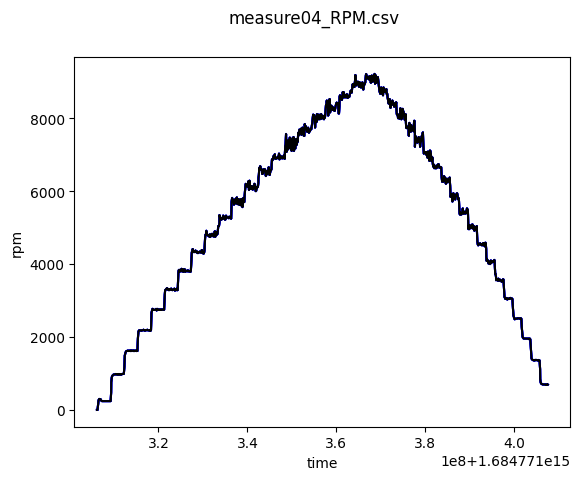